In [12]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score

In [16]:
def fcnCalculateMSE(y):
    if len(y) == 0:
        return 0
    else:
        yPred = np.mean(y)
        return np.mean((y - yPred) ** 2)

In [17]:
class Node:

    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None
    
class ID3DecisionTreeRegressor:
    
    def __init__(self, min_sample_split = 2, max_depth = 100, n_feats = None, threshold_for_category = 10):
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        self.FeatureType = None
        self.threshold_for_category = threshold_for_category
        self.y = None
        
    def _label_categorical_features(self, y):
        yUnique = np.unique(y)
        Y = np.zeros(len(y) , dtype = int)
        for intCtr in range(0, len(y)):
            Y[intCtr] = np.argwhere(y[intCtr] == yUnique)
        return Y

    
    def _determine_feature_type(self, X):
        lstFeatureType = []
        for intFeatureIterator in range(0, X.shape[1]):
            if len(np.unique(X[:, intFeatureIterator])) <= self.threshold_for_category or isinstance(np.unique(X[:, intFeatureIterator]), str):
                lstFeatureType.append("Categorical")
            else:
                lstFeatureType.append("Continuous")
        
        return lstFeatureType
        
    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(X.shape[1], self.n_feats)
        self.FeatureType = self._determine_feature_type(X)
        self.y = y
        self.root = self._grow_tree(X, y)
        
    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_sample_split):
            leaf_value = self._mean(y)
            return Node(value = leaf_value)
        
        feat_idxs = np.random.choice(n_features, self.n_feats, replace = False)
        
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._Split(X[:, best_feat], best_thresh, self.FeatureType[best_feat])
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feat, best_thresh, left, right)       
    
    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            feature_type = self.FeatureType[feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(self.y, X_column, threshold, feature_type)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh
    
  
    def _information_gain(self, y, X_column, split_thresh, feature_type):
        parent_entropy = fcnCalculateMSE(y)
        
        left_idxs, right_idxs = self._Split(X_column, split_thresh, feature_type)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = fcnCalculateMSE(y[left_idxs]), fcnCalculateMSE(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        ig = parent_entropy - child_entropy
        return ig
         
    
    def _Split(self, X_column, split_thresh, feature_type):
        if feature_type == "Continuous":
            left_idxs = np.argwhere(X_column <= split_thresh).flatten()
            right_idxs = np.argwhere(X_column > split_thresh).flatten()
        else:
            left_idxs = np.argwhere(X_column == split_thresh).flatten()
            right_idxs = np.argwhere(X_column != split_thresh).flatten()            
        return left_idxs, right_idxs
        
    def _mean(self, y):
        return np.mean(y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, X, node):
        if node.is_leaf_node():
            return node.value

        if self.FeatureType[node.feature] == "Categorical":
            if X[node.feature] == node.threshold:
                return self._traverse_tree(X, node.left)
            return self._traverse_tree(X, node.right)        
        else:
            if X[node.feature] <= node.threshold:
                return self._traverse_tree(X, node.left)

            return self._traverse_tree(X, node.right)

def fcnAccuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [10]:
#Generating a random linear dataset

def fcnCreateDataset(intNumberOfSamples, intVariance, intStep = 2, strCorrelation = "P"):
    intValue = 1
    X = []
    Y = []
    for intCtr in range(1,intNumberOfSamples):
        X.append(intCtr)
        Y.append(intCtr + random.randrange(-intVariance,intVariance))
        if strCorrelation == "P":
            intValue += intStep
        else:
            intValue -= intStep
    
    return np.array(X, dtype=np.float64), np.array(Y, dtype=np.float64),    

In [13]:
#Splitting the data

x, y = fcnCreateDataset(200,100,5,"P")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [42]:
dt = ID3DecisionTreeRegressor(max_depth=100, threshold_for_category=10)
dt.fit(x_train.reshape(-1,1), y_train)
    
y_pred = dt.predict(x_test.reshape(-1,1))
r2 = r2_score(y_test, y_pred)

print ("Accuracy:", r2)

Accuracy: -0.4213564602456785


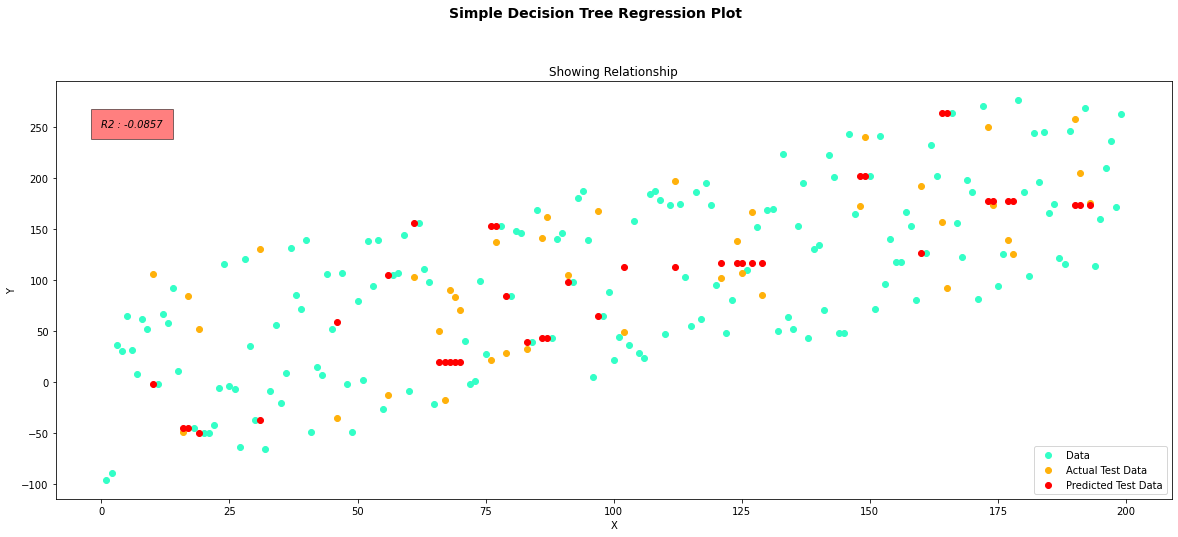

In [27]:
#Plotting all the datapoints

fig = plt.figure(figsize=(20,8))
fig.suptitle("Simple Decision Tree Regression Plot", fontsize=14, fontweight="bold")
ax = fig.add_subplot(111)
fig.subplots_adjust(top = 0.85)
ax.set_title("Showing Relationship")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.text(0, 250, "R2 : {}".format(np.round(r2, 4)) , style = 'italic', bbox = {'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.scatter(x_train, y_train, color='#33FFC7',label = 'Data')
plt.scatter(x_test, y_test, color='#FFB10B', label = "Actual Test Data")
plt.scatter(x_test, y_pred, color='r', label = "Predicted Test Data")
plt.legend(loc=4)
plt.show()

In [31]:
dt2 = DecisionTreeRegressor()
dt2.fit(x_train.reshape(-1,1), y_train)
    
y_pred2 = dt2.predict(x_test.reshape(-1,1))
R2 = r2_score(y_test, y_pred2)

print ("Accuracy:", R2)

Accuracy: -0.22332149318787375
